In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Încarcă datele
df = pd.read_csv('IMLP4_TASK_03-products.csv')

# IMPORTANT: Curăță numele coloanelor (elimină spații)
df.columns = df.columns.str.strip()

print(" Coloane după curățare:")
print(df.columns.tolist())
print("\n" + "="*60 + "\n")

# Primele 5 produse
print(" Primele 5 produse:")
print(df.head())

# Informații generale
print(f"\n Total produse: {len(df)}")
print(f" Total categorii: {df['Category Label'].nunique()}")

# Top 10 categorii
print("\n Top 10 categorii:")
print(df['Category Label'].value_counts().head(10))


 Coloane după curățare:
['product ID', 'Product Title', 'Merchant ID', 'Category Label', '_Product Code', 'Number_of_Views', 'Merchant Rating', 'Listing Date']


 Primele 5 produse:
   product ID                                      Product Title  Merchant ID  \
0           1                    apple iphone 8 plus 64gb silver            1   
1           2                apple iphone 8 plus 64 gb spacegrau            2   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            3   
3           4                apple iphone 8 plus 64gb space grey            4   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            5   

  Category Label _Product Code  Number_of_Views  Merchant Rating Listing Date  
0  Mobile Phones    QA-2276-XC            860.0              2.5    5/10/2024  
1  Mobile Phones    KA-2501-QO           3772.0              4.8   12/31/2024  
2  Mobile Phones    FP-8086-IE           3092.0              3.9   11/10/2024  
3  Mobile P

In [6]:
# Verifică valori lipsă
print("Valori lipsă pe coloane:")
print(df.isnull().sum())

# Verifică duplicate
print(f"Produse duplicate: {df.duplicated(subset=['Product Title']).sum()}")


Valori lipsă pe coloane:
product ID           0
Product Title      172
Merchant ID          0
Category Label      44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
Listing Date        59
dtype: int64
Produse duplicate: 4450


In [7]:
# Elimină duplicate
df = df.drop_duplicates(subset=['Product Title'])

# Curăță textul titlurilor
df['Product Title'] = df['Product Title'].str.lower()
df['Product Title'] = df['Product Title'].str.strip()

# Păstrează doar categoriile cu >10 produse
category_counts = df['Category Label'].value_counts()
valid_categories = category_counts[category_counts >= 10].index
df = df[df['Category Label'].isin(valid_categories)]

print(f"După curățare: {len(df)} produse")
print(f"Categorii păstrate: {df['Category Label'].nunique()}")


După curățare: 30823 produse
Categorii păstrate: 13


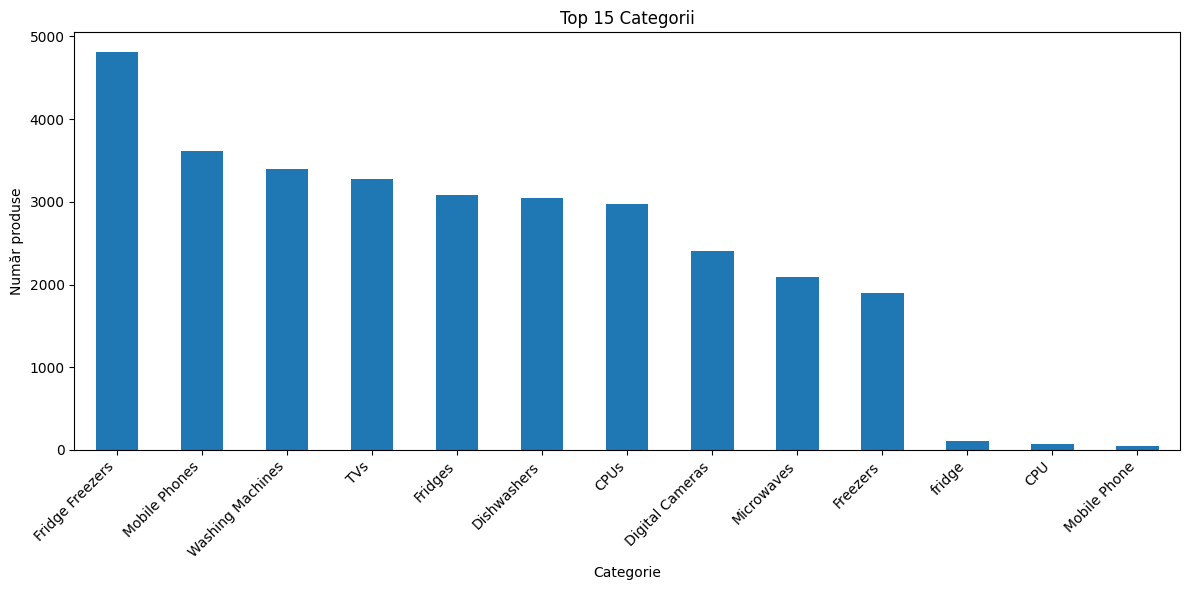

In [11]:
# Grafic cu top categorii
plt.figure(figsize=(12, 6))
df['Category Label'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Categorii')
plt.xlabel('Categorie')
plt.ylabel('Număr produse')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
import re

# MAI ÎNTÂI: Elimină rândurile cu Product Title lipsă
print(f"Înainte de eliminare: {len(df)} produse")
df = df.dropna(subset=['Product Title'])
print(f"După eliminare: {len(df)} produse")
print(f"Eliminate: produse fără titlu\n")

# Funcție pentru a extrage caracteristici
def extract_features(df):
    # Lungimea titlului
    df['title_length'] = df['Product Title'].str.len()

    # Câte cuvinte are
    df['word_count'] = df['Product Title'].str.split().str.len()

    # Are numere? (1=da, 0=nu)
    df['has_numbers'] = df['Product Title'].str.contains(r'\d').astype(int)

    # Câte numere are
    df['number_count'] = df['Product Title'].str.count(r'\d')

    # Cuvântul cel mai lung
    df['max_word_length'] = df['Product Title'].apply(
        lambda x: max([len(w) for w in x.split()]) if x.split() else 0
    )

    # Are brand cunoscut?
    brands = ['samsung', 'apple', 'sony', 'lg', 'bosch', 'canon', 'hp']
    df['has_brand'] = df['Product Title'].apply(
        lambda x: any(brand in x for brand in brands)
    ).astype(int)

    return df

# Aplică funcția
df = extract_features(df)

# Vezi ce ai creat
print("Caracteristici create:")
print(df[['Product Title', 'title_length', 'word_count', 'has_numbers', 'has_brand']].head(10))

print("\nStatistici despre caracteristici:")
print(df[['title_length', 'word_count', 'has_numbers', 'number_count', 'max_word_length', 'has_brand']].describe())

Înainte de eliminare: 30823 produse
După eliminare: 30822 produse
Eliminate: produse fără titlu

Caracteristici create:
                                        Product Title  title_length  \
0                     apple iphone 8 plus 64gb silver            31   
1                 apple iphone 8 plus 64 gb spacegrau            35   
2   apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            70   
3                 apple iphone 8 plus 64gb space grey            35   
4   apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            54   
6                apple iphone 8 plus 64 gb space grey            36   
10  apple iphone 8 plus 5.5 single sim 4g 64gb silver            49   
11    sim free iphone 8 plus 64gb by apple space grey            47   
12           apple iphone 8 plus 64gb gold smartphone            40   
13    apple iphone 8 plus 5.5 single sim 4g 64gb grey            47   

    word_count  has_numbers  has_brand  
0            6            1          1  
1            7  

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# Pregătește datele
X_text = df['Product Title']
y = df['Category Label']

# Transformă textul în numere (TF-IDF)
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X_text)

# Caracteristicile pe care le-am creat
feature_cols = ['title_length', 'word_count', 'has_numbers',
                'number_count', 'max_word_length', 'has_brand']
X_features = df[feature_cols].values

# Combină tot
X_combined = hstack([X_tfidf, X_features])

# Împarte în train (80%) și test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Date antrenare: {X_train.shape[0]}")
print(f"Date testare: {X_test.shape[0]}")

Date antrenare: 24657
Date testare: 6165


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Creează modelul
model = LogisticRegression(max_iter=1000, random_state=42)

print("Antrenez modelul... (durează 1-2 minute)")

# Antrenează
model.fit(X_train, y_train)

# Testează
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"GATA! Acuratețe: {accuracy:.2%}")
print(f"Din 100 de produse, modelul ghicește corect ~{int(accuracy*100)}!")

Antrenez modelul... (durează 1-2 minute)
GATA! Acuratețe: 93.25%
Din 100 de produse, modelul ghicește corect ~93!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
import pickle

# Pune tot ce ai nevoie într-un pachet
model_package = {
    'model': model,
    'tfidf': tfidf,
    'feature_columns': feature_cols
}

# Salvează
with open('product_classifier.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model salvat în 'product_classifier.pkl'!")

# Download-ează fișierul
from google.colab import files
files.download('product_classifier.pkl')

Model salvat în 'product_classifier.pkl'!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
def predict_product(title):
    # Pregătește titlul
    title_clean = title.lower().strip()

    # Extrage features
    features = {
        'title_length': len(title_clean),
        'word_count': len(title_clean.split()),
        'has_numbers': int(bool(re.search(r'\d', title_clean))),
        'number_count': len(re.findall(r'\d', title_clean)),
        'max_word_length': max([len(w) for w in title_clean.split()]) if title_clean.split() else 0,
        'has_brand': int(any(b in title_clean for b in ['samsung', 'apple', 'sony', 'lg', 'bosch']))
    }

    # Transformă text
    X_tfidf = tfidf.transform([title_clean])
    X_feat = [[features[col] for col in feature_cols]]
    X_final = hstack([X_tfidf, X_feat])

    # Prezice
    prediction = model.predict(X_final)[0]
    proba = model.predict_proba(X_final)[0]
    confidence = max(proba)

    return prediction, confidence

# TESTEAZĂ CU EXEMPLE:
test_products = [
    "iphone 7 32gb gold",
    "samsung galaxy a52 128gb",
    "bosch washing machine 8kg"
]

print("TESTARE MODELE:")
for product in test_products:
    category, conf = predict_product(product)
    print(f"'{product}'")
    print(f"   Categorie: {category}")
    print(f"   Încredere: {conf:.1%}")

TESTARE MODELE:
'iphone 7 32gb gold'
   Categorie: Mobile Phones
   Încredere: 95.7%
'samsung galaxy a52 128gb'
   Categorie: Mobile Phones
   Încredere: 96.5%
'bosch washing machine 8kg'
   Categorie: Washing Machines
   Încredere: 99.8%
